# Data Analytics Project - Models

# Pair 4 - ASHOKLEY Linear Regression Model

---

# 1. Import required modules

In [1]:
import numpy as np
import pandas as pd
from fastai.tabular.core import add_datepart
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from regressors import stats

/home/varun487/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


---

# 2. Get Pair 4 Orders Dataset

## 2.1. Get the orders

In [2]:
orders_df = pd.read_csv('../../Preprocess/Pair4/Pair4_orders.csv')
orders_df.head()

,Date,ASHOKLEY_Close,TATAMTRDVR_Close,Spread,zscore,Orders
0,2019-05-17,84.500000,83.199997,1.300003,-1.764996,LONG
1,2019-05-20,87.550003,88.849998,-1.299995,-2.747445,LONG
2,2019-05-21,88.250000,83.150002,5.099998,-0.329109,FLAT
3,2019-05-22,87.849998,85.400002,2.449997,-1.330453,FLAT
4,2019-05-23,88.849998,84.849998,4.000000,-0.744760,FLAT


In [3]:
orders_df.tail()

,Date,ASHOKLEY_Close,TATAMTRDVR_Close,Spread,zscore,Orders
57,2019-08-07,61.150002,55.650002,5.500000,-0.177963,FLAT
58,2019-08-08,63.549999,58.750000,4.799999,-0.442469,FLAT
59,2019-08-09,64.300003,58.200001,6.100002,0.048757,FLAT
60,2019-08-13,61.549999,57.700001,3.849998,-0.801441,FLAT
61,2019-08-14,62.549999,57.349998,5.200001,-0.291322,FLAT


## 2.2. Visualize the orders

Text(0, 0.5, 'zscore')

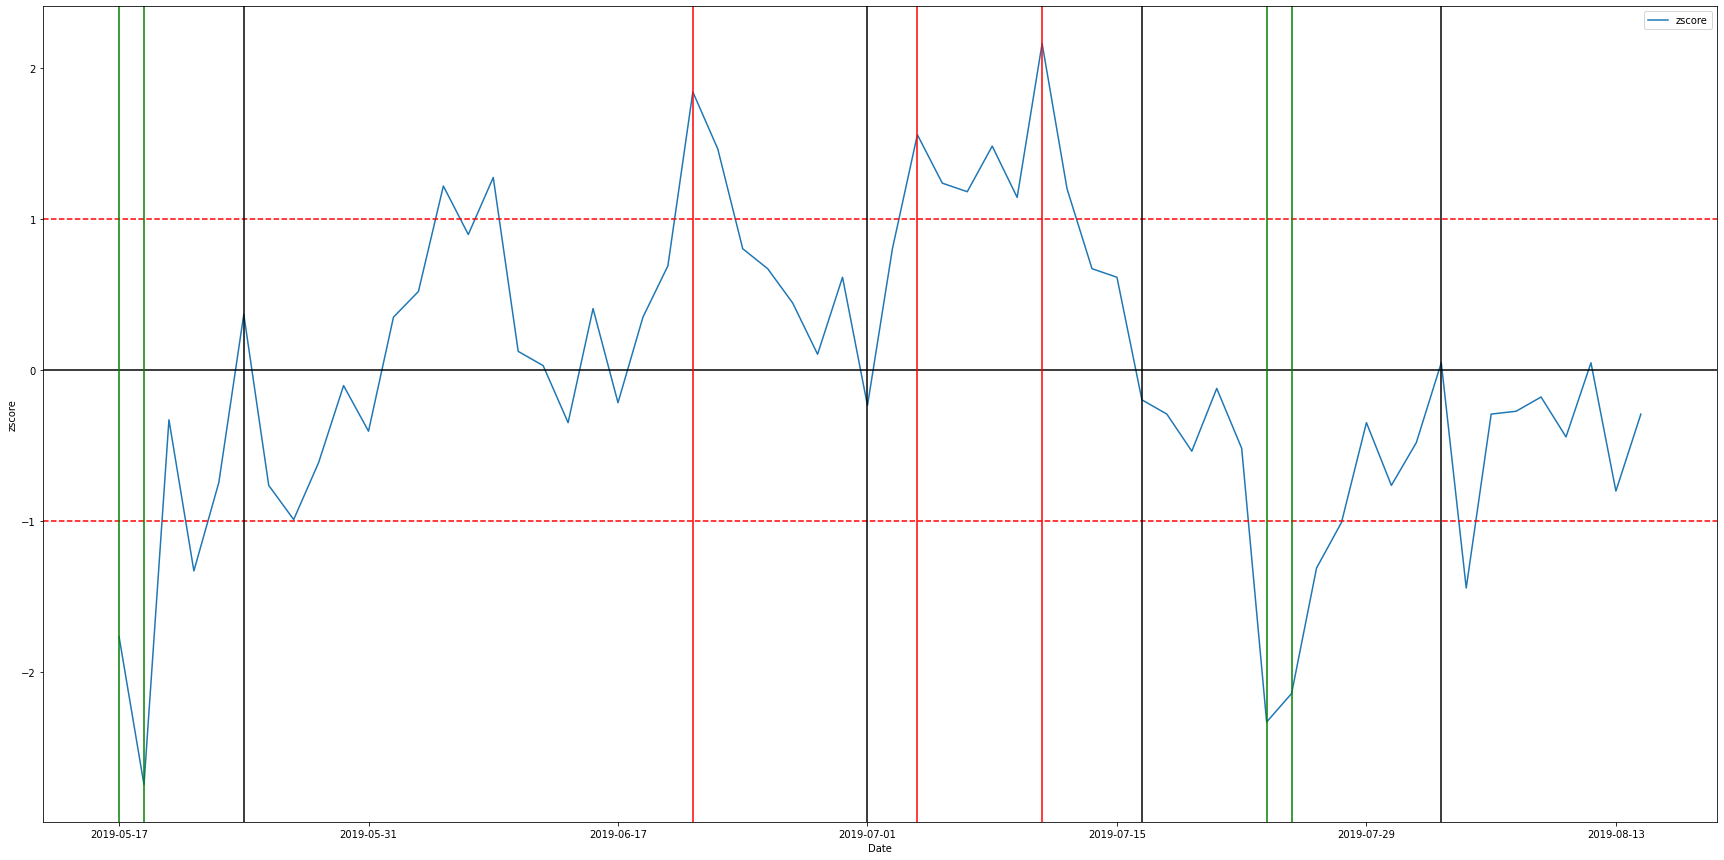

In [4]:
# Plotting the zscore of the Spread
orders_plt = orders_df.plot(x='Date', y='zscore', figsize=(30,15))

# Plotting the lines at mean, 1 and 2 std. dev.
orders_plt.axhline(0, c='black')
orders_plt.axhline(1, c='red', ls = "--")
orders_plt.axhline(-1, c='red', ls = "--")

# Extracting orders
Orders = orders_df['Orders']

# Plot vertical lines where orders are placed
for order in range(len(Orders)):
    
    if Orders[order] != "FLAT":
        
        # GREEN line for a long position
        if Orders[order] == "LONG":
            orders_plt.axvline(x=order, c = "green")
        
        # RED line for a short position
        elif Orders[order] == "SHORT":
            orders_plt.axvline(x=order, c = "red")
        
        # BLACK line for getting out of all positions at that point
        else:
            orders_plt.axvline(x=order, c = "black")

orders_plt.set_ylabel("zscore")

__In the figure above:__
- __Blue line__ - zscore of the Spread
- __Black horizontal line__ at 0 - Mean
- __Red dotted horizontal lines__ - at +1 and -1 standard deviations
- __Green vertical line__ - represents long position taken on that day
- __Red vertical line__ - represents short position taken on that day
- __Black vertical line__ - represents getting out of all open positions till that point


## 2.3 Visualize the close prices of both stocks

Text(0, 0.5, 'Price')

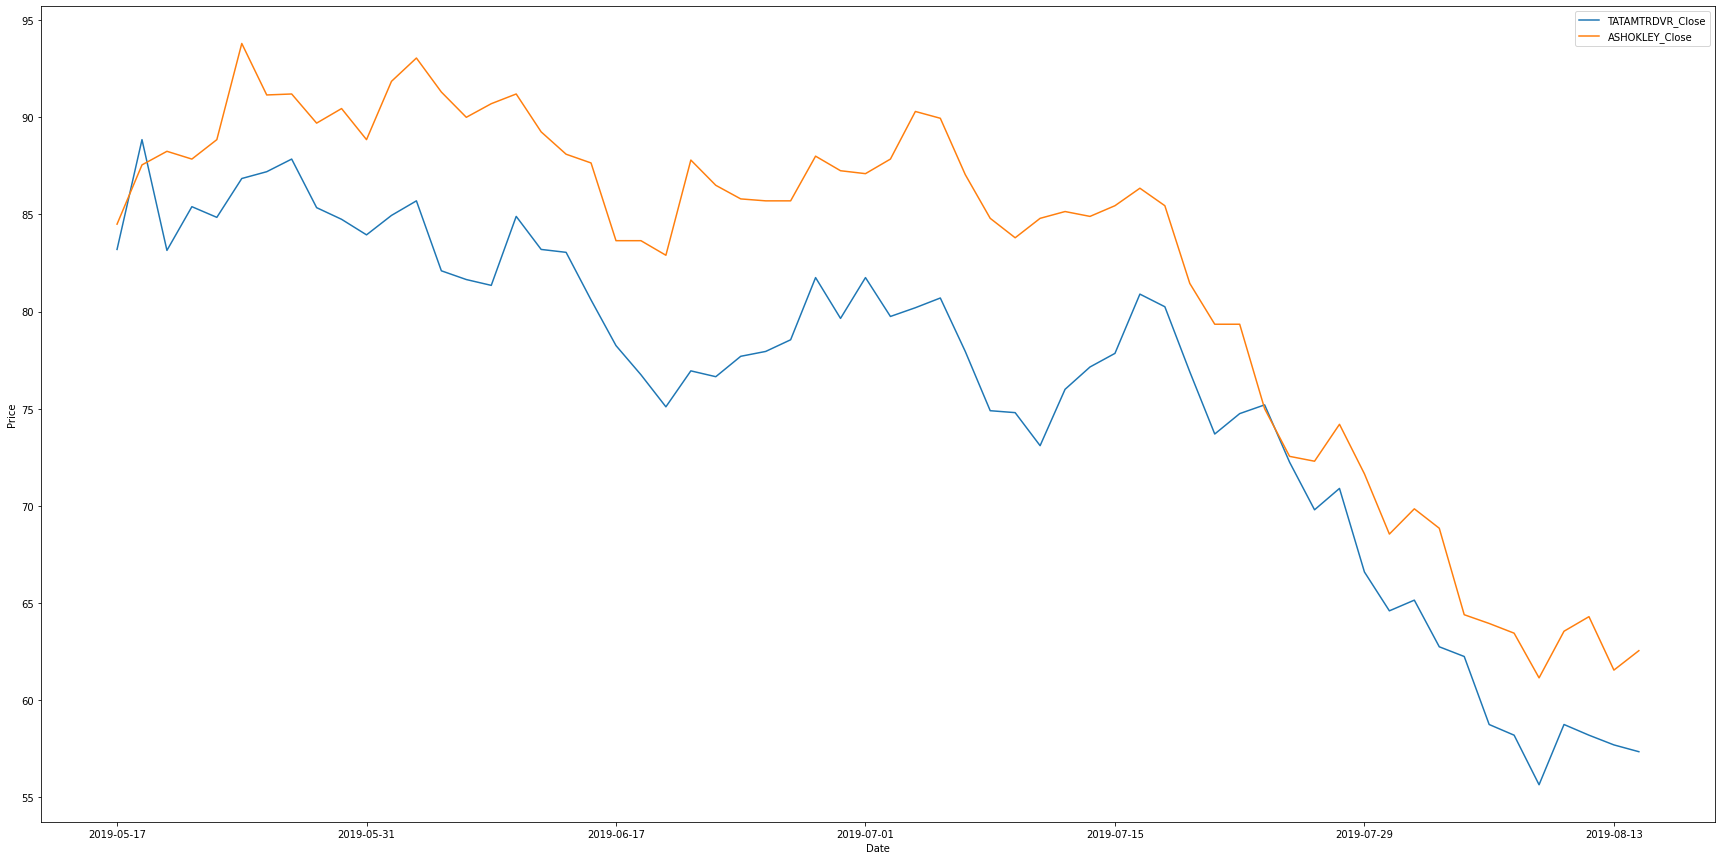

In [5]:
orders_df_plt = orders_df.plot(x='Date', y=['TATAMTRDVR_Close', 'ASHOKLEY_Close'], figsize=(30,15))
orders_df_plt.set_xlabel("Date")
orders_df_plt.set_ylabel("Price")

---

# 3. ASHOKLEY Linear Regression Model

## 3.1. Get the Complete ASHOKLEY dataset

In [6]:
ashokley_df = pd.read_csv("../../Storage/Companies_with_names_exchange/ASHOKLEYNSE.csv")
ashokley_df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Company,Exchange
0,2017-01-02,81.500000,79.150002,80.500000,81.000000,12823600.0,81.000000,ASHOKLEY,NSE
1,2017-01-03,81.550003,80.449997,81.400002,81.050003,7610206.0,81.050003,ASHOKLEY,NSE
2,2017-01-04,84.550003,81.250000,81.500000,83.849998,14148219.0,83.849998,ASHOKLEY,NSE
3,2017-01-05,84.949997,82.800003,84.650002,83.949997,10474833.0,83.949997,ASHOKLEY,NSE
4,2017-01-06,85.699997,83.150002,84.199997,85.300003,10508449.0,85.300003,ASHOKLEY,NSE


- We can see that we have data from 2017-01-02

## 3.2. Get ASHOKLEY training data

### 3.2.1 Get complete ashokley dataset

In [7]:
ashokley_df = ashokley_df.drop(columns=['High', 'Low', 'Open', 'Volume', 'Adj Close', 'Company', 'Exchange'])
ashokley_df.head()

,Date,Close
0,2017-01-02,81.000000
1,2017-01-03,81.050003
2,2017-01-04,83.849998
3,2017-01-05,83.949997
4,2017-01-06,85.300003


- We can see that the period where the stocks are correlated and co-integration starts from 2018-09-04.
- Thus the test data for which we need to make predictions is from 2018-09-04 to when the period ends at 2018-12-03.
- We take 1 year's worth of training data for our model, which means that the time period of our training data is from 2017-09-03 to 2018-09-04.


### 3.2.2. Crop dataset within training range

In [8]:
ashokley_df_train = ashokley_df[ashokley_df['Date'] >= '2017-09-03']
ashokley_df_train.head()

,Date,Close
166,2017-09-04,113.349998
167,2017-09-05,113.000000
168,2017-09-06,112.150002
169,2017-09-07,111.900002
170,2017-09-08,115.150002


In [9]:
ashokley_df_train = ashokley_df_train[ashokley_df_train['Date'] <= '2018-09-04']
ashokley_df_train.tail()

,Date,Close
412,2018-08-29,131.899994
413,2018-08-30,130.850006
414,2018-08-31,129.050003
415,2018-09-03,133.449997
416,2018-09-04,127.849998


### 3.2.3 Add extra date columns to the training data

In [10]:
add_datepart(ashokley_df_train, 'Date')

,Close,Year,Week,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
166,113.349998,2017,36,9,4,0,247,False,False,False,False,False,False,1504483200
167,113.000000,2017,36,9,5,1,248,False,False,False,False,False,False,1504569600
168,112.150002,2017,36,9,6,2,249,False,False,False,False,False,False,1504656000
169,111.900002,2017,36,9,7,3,250,False,False,False,False,False,False,1504742400
170,115.150002,2017,36,9,8,4,251,False,False,False,False,False,False,1504828800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,131.899994,2018,35,8,29,2,241,False,False,False,False,False,False,1535500800
413,130.850006,2018,35,8,30,3,242,False,False,False,False,False,False,1535587200
414,129.050003,2018,35,8,31,4,243,True,False,False,False,False,False,1535673600
415,133.449997,2018,36,9,3,0,246,False,False,False,False,False,False,1535932800


### 3.2.4 Get the training data and labels

In [11]:
ashokley_train_X = ashokley_df_train.copy()

In [12]:
ashokley_train_X = ashokley_train_X.reset_index(drop=True)
ashokley_train_X_plot = ashokley_train_X.copy()
ashokley_train_X = ashokley_train_X.drop(columns=["Elapsed", "Close"])
ashokley_train_X.head()

,Year,Week,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
0,2017,36,9,4,0,247,False,False,False,False,False,False
1,2017,36,9,5,1,248,False,False,False,False,False,False
2,2017,36,9,6,2,249,False,False,False,False,False,False
3,2017,36,9,7,3,250,False,False,False,False,False,False
4,2017,36,9,8,4,251,False,False,False,False,False,False


In [13]:
ashokley_train_X.tail()

,Year,Week,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
246,2018,35,8,29,2,241,False,False,False,False,False,False
247,2018,35,8,30,3,242,False,False,False,False,False,False
248,2018,35,8,31,4,243,True,False,False,False,False,False
249,2018,36,9,3,0,246,False,False,False,False,False,False
250,2018,36,9,4,1,247,False,False,False,False,False,False


In [14]:
ashokley_train_y = ashokley_df[(ashokley_df['Date'] >= '2017-09-04') & (ashokley_df['Date'] <= '2018-09-04')]['Close']
ashokley_train_y

166    113.349998
167    113.000000
168    112.150002
169    111.900002
170    115.150002
          ...    
412    131.899994
413    130.850006
414    129.050003
415    133.449997
416    127.849998
Name: Close, Length: 251, dtype: float64

In [15]:
len(ashokley_train_X)

251

In [16]:
len(ashokley_train_y)

251

## 3.3. Get ASHOKLEY Test Data

In [17]:
ashokley_test_df = orders_df.copy()
ashokley_test_df = ashokley_df[(ashokley_df['Date'] >= '2018-09-04') & (ashokley_df['Date'] <= '2018-12-03')].copy()
ashokley_test_df.head()

,Date,Close
416,2018-09-04,127.849998
417,2018-09-05,127.449997
418,2018-09-06,129.699997
419,2018-09-07,132.000000
420,2018-09-10,129.649994


In [18]:
ashokley_test_df.tail()

,Date,Close
470,2018-11-27,110.300003
471,2018-11-28,108.349998
472,2018-11-29,110.150002
473,2018-11-30,112.349998
474,2018-12-03,107.150002


In [19]:
add_datepart(ashokley_test_df, 'Date')
ashokley_test_df.head()

,Close,Year,Week,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
416,127.849998,2018,36,9,4,1,247,False,False,False,False,False,False,1536019200
417,127.449997,2018,36,9,5,2,248,False,False,False,False,False,False,1536105600
418,129.699997,2018,36,9,6,3,249,False,False,False,False,False,False,1536192000
419,132.000000,2018,36,9,7,4,250,False,False,False,False,False,False,1536278400
420,129.649994,2018,37,9,10,0,253,False,False,False,False,False,False,1536537600


In [20]:
ashokley_test_X = ashokley_test_df.copy()
ashokley_test_X = ashokley_test_X.drop(columns=['Close', "Elapsed"])
ashokley_test_X.reset_index(drop=True, inplace=True)
ashokley_test_X.index += 251
ashokley_test_X.head()

,Year,Week,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
251,2018,36,9,4,1,247,False,False,False,False,False,False
252,2018,36,9,5,2,248,False,False,False,False,False,False
253,2018,36,9,6,3,249,False,False,False,False,False,False
254,2018,36,9,7,4,250,False,False,False,False,False,False
255,2018,37,9,10,0,253,False,False,False,False,False,False


In [21]:
ashokley_test_X.tail()

,Year,Week,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
305,2018,48,11,27,1,331,False,False,False,False,False,False
306,2018,48,11,28,2,332,False,False,False,False,False,False
307,2018,48,11,29,3,333,False,False,False,False,False,False
308,2018,48,11,30,4,334,True,False,False,False,False,False
309,2018,49,12,3,0,337,False,False,False,False,False,False


In [22]:
ashokley_test_y = ashokley_df[(ashokley_df['Date'] >= '2018-09-04') & (ashokley_df['Date'] <= '2018-12-03')]
ashokley_test_y.reset_index(drop=True, inplace=True)
ashokley_test_y.index += 251
ashokley_test_y = ashokley_test_y['Close']

In [23]:
ashokley_test_y

251    127.849998
252    127.449997
253    129.699997
254    132.000000
255    129.649994
256    127.750000
257    127.849998
258    131.250000
259    127.449997
260    126.400002
261    125.800003
262    122.300003
263    120.349998
264    121.900002
265    120.650002
266    120.400002
267    119.099998
268    120.150002
269    119.150002
270    118.050003
271    107.750000
272    109.150002
273    110.849998
274    114.550003
275    111.800003
276    115.800003
277    117.050003
278    120.550003
279    114.300003
280    112.500000
281    112.800003
282    111.449997
283    116.800003
284    112.849998
285    113.150002
286    115.250000
287    115.000000
288    114.699997
289    113.349998
290    117.699997
291    120.699997
292    120.900002
293    121.849998
294    118.250000
295    118.300003
296    119.000000
297    106.500000
298    106.099998
299    105.550003
300    108.800003
301    107.650002
302    110.300003
303    109.300003
304    108.900002
305    110.300003
306    108

In [24]:
len(ashokley_test_X)

59

In [25]:
len(ashokley_test_y)

59

## 3.4 Create and Train ASHOKLEY Model

In [26]:
model = LinearRegression()
model = model.fit(ashokley_train_X, ashokley_train_y)

## 3.5. Get predictions

In [27]:
predictions = model.predict(ashokley_test_X)
predictions_df = pd.DataFrame(predictions, columns=['predictions'])
predictions_df.index += 251
predictions_df

,predictions
251,120.973240
252,120.949883
253,120.926525
254,120.903168
255,120.150063
256,120.126706
257,120.103348
258,120.056633
259,119.303529
260,119.280171


In [28]:
predictions_df['test_data'] = ashokley_test_y
predictions_df

,predictions,test_data
251,120.973240,127.849998
252,120.949883,127.449997
253,120.926525,129.699997
254,120.903168,132.000000
255,120.150063,129.649994
256,120.126706,127.750000
257,120.103348,127.849998
258,120.056633,131.250000
259,119.303529,127.449997
260,119.280171,126.400002


In [29]:
predictions = predictions_df['predictions']
predictions

251    120.973240
252    120.949883
253    120.926525
254    120.903168
255    120.150063
256    120.126706
257    120.103348
258    120.056633
259    119.303529
260    119.280171
261    119.256814
262    119.210099
263    118.456994
264    118.433637
265    118.410279
266    118.386922
267    118.363564
268    114.075752
269    123.204455
270    123.181097
271    123.157740
272    122.404635
273    122.381278
274    122.357920
275    122.334563
276    122.311205
277    121.558101
278    121.534743
279    121.511386
280    121.464670
281    120.711566
282    120.688209
283    120.664851
284    120.641493
285    120.618136
286    119.865032
287    119.841674
288    124.280191
289    114.715760
290    115.021661
291    114.268557
292    114.245199
293    114.221842
294    114.175126
295    113.422022
296    113.398665
297    113.375307
298    113.351949
299    113.328592
300    112.575488
301    112.552130
302    112.528772
303    112.505415
304    111.728953
305    111.705595
306    111

In [30]:
print('Mean Absolute Error:', metrics.mean_absolute_error(ashokley_test_y, predictions))
print('Mean Squared Error:', metrics.mean_squared_error(ashokley_test_y, predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(ashokley_test_y, predictions)))
print('R2 Score:', metrics.r2_score(ashokley_test_y, predictions))

Mean Absolute Error: 6.091052521765293
Mean Squared Error: 47.31089456215834
Root Mean Squared Error: 6.878291543847086
R2 Score: 0.06604911596500762


## 3.6. Visualize the predicitons vs test data

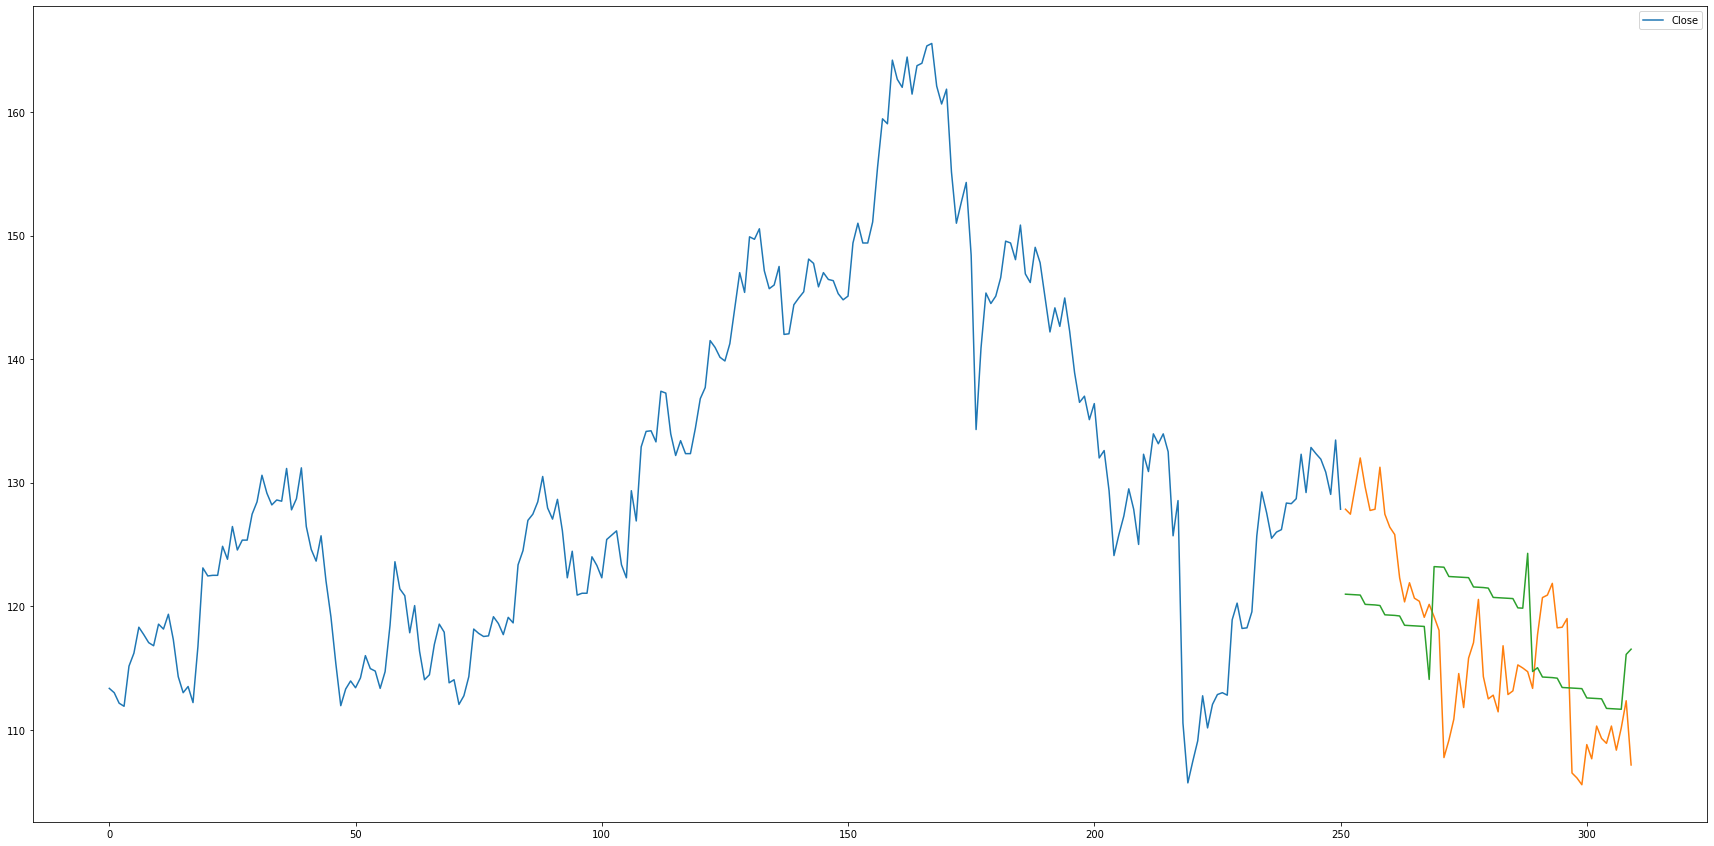

In [31]:
ashokley_model_plt = ashokley_train_X_plot.plot(y=['Close'], figsize=(30,15))
ashokley_model_plt.plot(predictions_df['test_data'])
ashokley_model_plt.plot(predictions_df['predictions'])

__In the graph above:__
- We can see the training data in blue
- The test data in orange
- The predictions made by the models in green

# 4. Put the results into a file

In [32]:
ashokley_predictions_data = {'Date': orders_df['Date'], 'Actual_Close': orders_df['ASHOKLEY_Close']}
ashokley_predictions_df = pd.DataFrame(ashokley_predictions_data)
ashokley_predictions_df.head()

,Date,Actual_Close
0,2019-05-17,84.500000
1,2019-05-20,87.550003
2,2019-05-21,88.250000
3,2019-05-22,87.849998
4,2019-05-23,88.849998


In [33]:
predictions_df = predictions_df.reset_index()
ashokley_predictions_df['Linear_regression_Close'] = predictions_df['predictions']
ashokley_predictions_df.head()

,Date,Actual_Close,Linear_regression_Close
0,2019-05-17,84.500000,120.973240
1,2019-05-20,87.550003,120.949883
2,2019-05-21,88.250000,120.926525
3,2019-05-22,87.849998,120.903168
4,2019-05-23,88.849998,120.150063


In [34]:
ashokley_predictions_df.to_csv('Ashokley_predicitions.csv', index=False)